# Regularisation for Inverse Problems

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage import data
from scipy.signal import convolve2d as conv2
from scipy.fft import fft2, ifft2
from skimage.util import random_noise
from skimage.restoration import wiener, richardson_lucy, denoise_tv_chambolle

# helper function for forward operator
def K(inp,psf=[],mode='forward',alpha=1e-16):
    n = inp.shape[0]
    k_hat = fft2(psf,s=(n,n))
    inp_hat = fft2(inp)
    if mode == 'forward':
        outp = ifft2(k_hat * inp_hat)
    if mode == 'adjoint':
        outp = ifft2(np.conj(k_hat) * inp_hat)
    if mode == 'pinv':
        g_hat = 1 / (np.conj(k_hat) * k_hat)
        g_hat[np.abs(k_hat)**2 <= alpha * np.amax(np.abs(k_hat), keepdims=False)] = 0
        outp = ifft2(( np.conj(k_hat) * inp_hat ) * (g_hat) )
        
    return np.real(outp)

# helper function for plotting
def plot_images(images, titles, fname=[], scale = [0,1]):
    m = len(images)
    fig, ax = plt.subplots(1,m)
    
    if m > 1:
        for k in range(m):
            ax[k].set_xticks([])
            ax[k].set_yticks([])
            ax[k].imshow(images[k], cmap=plt.cm.gray, vmin=scale[0], vmax=scale[1])
            ax[k].set_title(titles[k])
    else:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(images[0], cmap=plt.cm.gray, vmin=scale[0], vmax=scale[1])
        ax.set_title(titles[0])
    fig.set_figwidth(10)
    fig.tight_layout()
    
    if fname:
        plt.savefig(fname,dpi=300)

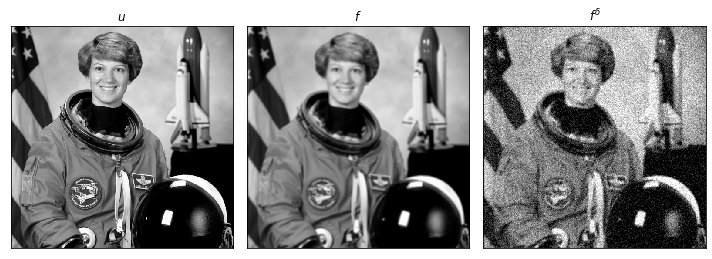

In [3]:
# read image
u = rgb2gray(data.astronaut())

# blur image
kernel = np.ones((5, 5)) / 25
f = K(u,psf=kernel)

# add_noise
delta = 0.01
f_delta = random_noise(f, var = delta, clip=False)

# plot
plot_images([u, f, f_delta], [r'$u$', r'$f$', r'$f^\delta$'], 'example1.png')

# A typical Inverse Problem ...

![](example1.png)

# Overview

* Inverse Problems
* Regularisation
* Sparse regularisation
* Data-driven regularisation

# Inverse problems in imaging

* $K$ - forward operator (convolution with PSF)
* $u$ - image (function or 2D array representing RGB values or intensity)
* $f$ - noiseless measurements ($f = Ku$)
* $f^\delta$ - noisey measurements ($f^\delta = f + \epsilon$ for additive noise)

> The goal is to retrieve $u$ given $K$ and $f^\delta$

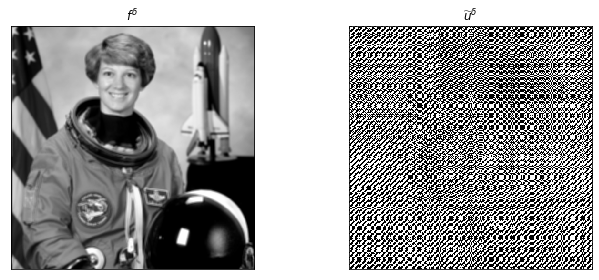

In [4]:
# read image
u = rgb2gray(data.astronaut())

# blur image
psf = np.ones((5, 5)) / 25
f = K(u, psf = kernel)

# add_noise
delta = 0
f_delta = random_noise(f, var = delta, clip=False)

# inverse
u_est = K(u, psf = kernel, mode = 'pinv', alpha = 1e-16)

# plot
plot_images([f_delta, u_est], [r'$f^\delta$', r'$\widetilde{u}^\delta$'], fname='decon_' + str(delta) + '.png')

We can naively retrieve the solution via deconvolution

$$\widetilde{u}^\delta = \mathcal{F}^{-1}\left(\frac{\widehat{f}^\delta}{\widehat{k}}\right).$$


This will amplify noise at frequencies for which $\widehat{k}$ is small

## $\delta = 0$
![](decon_0.png)

# Regularisation with linear filters

To avoid amplification of noise, we need to regularise the inverse filter.

Wiener filter:

$$\widetilde{u}^\delta_\alpha = \mathcal{F}^{-1} \left(\frac{\widehat{k}^*\widehat{f}^\delta}{|\widehat{k}|^2 + \alpha |\widehat{r}|^2}\right),$$

where $\widehat{r}$ is the psf of the regularistation operator.

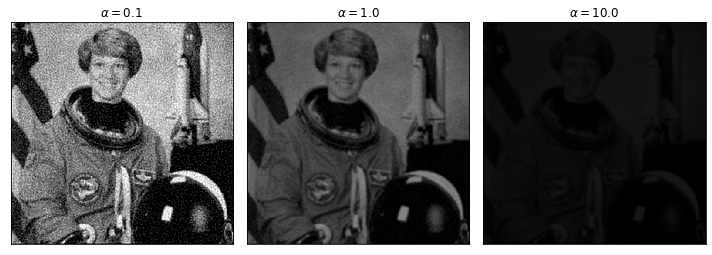

In [5]:
# read image
u = rgb2gray(data.astronaut())

# blur image
psf = np.ones((5, 5)) / 25
f = conv2(u, psf, 'same')

# add_noise
f_delta = random_noise(f, var = 0.01, clip=False)

# regularisation
reg_psf = np.zeros((5,5))
reg_psf[2,2] = 1

# apply inverse
alphas = [.1, 1.0, 10.0]
u_est = [0,0,0]
titles = [0,0,0]
for k in range(3):
    u_est[k] = wiener(f_delta, psf, reg = reg_psf, balance=alphas[k], clip=False) 
    titles[k] = r'$\alpha = $' + str(alphas[k])
# 
plot_images(u_est, titles, fname='decon_reg_id.png')

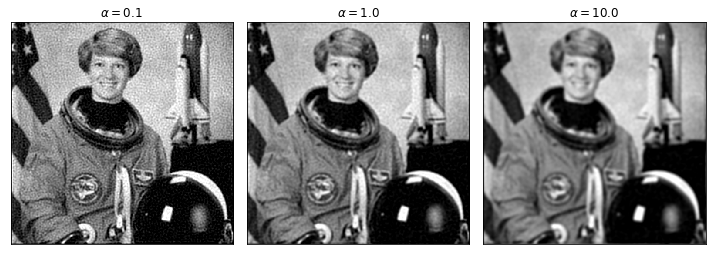

In [6]:
# read image
u = rgb2gray(data.astronaut())

# blur image
psf = np.ones((5, 5)) / 25
f = conv2(u, psf, 'same')

# add_noise
f_delta = random_noise(f, var = 0.01, clip=False)

# regularisation
reg_psf = np.array([[0,1,0],[1,-4,1],[0,1,0]])

# apply inverse
alphas = [.1, 1.0, 10.0]
u_est = [0,0,0]
titles = [0,0,0]
for k in range(3):
    u_est[k] = wiener(f_delta, psf, reg = reg_psf, balance=alphas[k], clip=False) 
    titles[k] = r'$\alpha = $' + str(alphas[k])
# 
plot_images(u_est, titles, fname='decon_reg_lap.png')

## $|\widehat{r}|^2 = 1$

![](decon_reg_id.png)

## $|\widehat{r}|^2 = |\xi|^2$

![](decon_reg_lap.png)

## Bias-variance trade-off

Regularisation reduces the influence of noise but introduces a bias.

$$\|u^\delta_\alpha - u\| \leq \|u^0_\alpha - u\| + \|u^\delta_\alpha - u^0_\alpha\|.$$

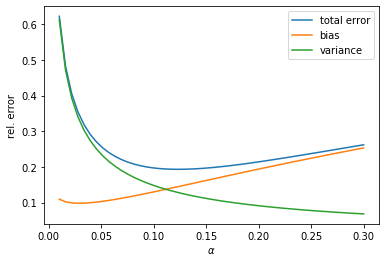

In [7]:
# read image
u = rgb2gray(data.astronaut())

# blur image
psf = np.ones((5, 5)) / 25
f = conv2(u, psf, 'same')

# add_noise
f_delta = random_noise(f, var = 0.01, clip=False)

# regularisation
reg_psf = np.array([[0,0,0],[0,1,0],[0,0,0]])

# apply inverse
ns = 50
alphas = np.linspace(.01,.3,ns)
error = np.zeros(ns)
bias = np.zeros(ns)
variance = np.zeros(ns)
for k in range(ns):
    u_delta_alpha = wiener(f_delta, psf, reg = reg_psf, balance=alphas[k], clip=False) 
    u_0_alpha = wiener(f, psf, reg = reg_psf, balance=alphas[k], clip=False)
    
    error[k] = np.linalg.norm(u_delta_alpha - u)/np.linalg.norm(u)
    bias[k] = np.linalg.norm(u_0_alpha - u)/np.linalg.norm(u)
    variance[k] = np.linalg.norm(u_0_alpha - u_delta_alpha)/np.linalg.norm(u)
# 
plt.plot(alphas,error,label='total error')
plt.plot(alphas,bias,label='bias')
plt.plot(alphas,variance,label='variance')
plt.legend()
plt.xlabel(r'$\alpha$')
plt.ylabel('rel. error')
plt.savefig('bias_variance.png',dpi=300)

![](bias_variance.png)

## A variational framework

The above-mentioned regularisation methods can be cast as a least-squares problem

$$\min_u \frac{1}{2\delta^2}\|Ku - f^\delta\|^2 + \frac{1}{2\lambda^2} \|Ru\|^2,$$

with $\alpha = (\delta / \lambda)^2$.

This quadratic problem has a closed-form solution

$$\widetilde{u}^\delta_\alpha = \left(K^*\!K + \alpha R^*\!R\right)^{-1}K^*f^\delta.$$

## A statistical interpretation

The solution can be interpreted as the most likely one, under the assumption that 

* $f^\delta = Ku + \epsilon$, with $\epsilon \sim \mathcal{N}(0,\delta^2)$
* $u \sim \mathcal{N}(0,\lambda (R^*\!R)^{-1})$.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


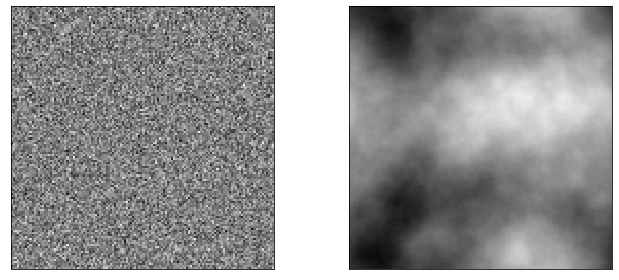

In [8]:
n = 128

# regularisation
reg_psf = np.array([[0,1,0],[1,-4,1],[0,1,0]])*n

# random image with diagonal covariance
u1 = .05*np.random.randn(n,n)

# random image with inverse Laplace covariance
z = np.random.randn(n,n)
u2 = K(z, psf = reg_psf, mode='pinv')
#
plot_images([u1,u2], ['',''], fname='bayesian.png', scale=[-.2,.2])

![](bayesian.png)

## Assignment: Richardson - Lucy

# Non-linear filters 

To succesfully denoise images, we need to preserve edges.

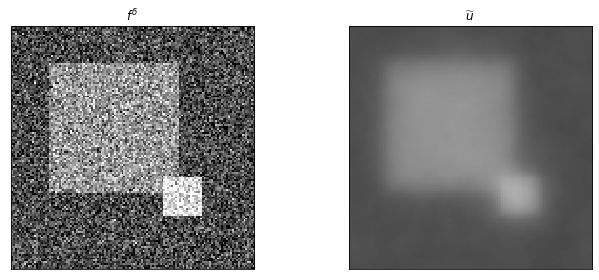

In [12]:
# make image
n = 128
u = np.zeros((n,n))
u[20:88, 20:88] = .5
u[80:100, 80:100] = 1

# add_noise
delta = 1e-1
f_delta = random_noise(u, var = delta, clip=False)

# filter
alpha = 5e1
reg_psf = np.array([[0,0,0],[0,1,0],[0,0,0]]) - alpha*np.array([[0,1,0],[1,-4,1],[0,1,0]])
u_est = K(f_delta, psf = reg_psf, mode='pinv')

# plot
plot_images([f_delta,u_est], [r'$f^\delta$',r'$\widetilde{u}$'], fname='denoise_linear.png', scale=[-.5,1.2])

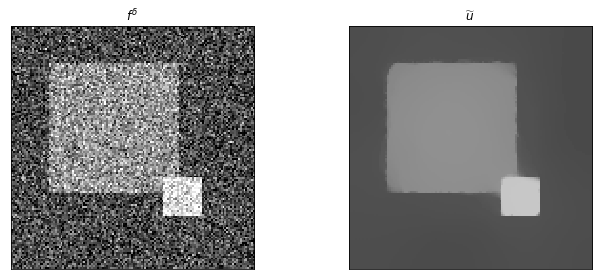

In [31]:
# make image
n = 128
u = np.zeros((n,n))
u[20:88, 20:88] = .5
u[80:100, 80:100] = 1

# add_noise
delta = 1e-1
f_delta = random_noise(u, var = delta, clip=False)

# filter
alpha = 1
u_est = denoise_tv_chambolle(f_delta, weight = alpha, eps=1e-6, n_iter_max=5000)

# plot
plot_images([f_delta,u_est], [r'$f^\delta$',r'$\widetilde{u}$'], fname='denoise_tv.png', scale=[-.5,1.2])

* Consider a simpeler problem first; denoising:

$$\min_u \frac{1}{2}\|u - f^\delta\|_2^2 + \alpha \|Ru\|_2^2.$$


* A linear filter would simply remove high-frequency content, thereby smoothing out edges:

$$\widetilde{u} = \left(I + \alpha R^*\!R\right)^{-1}f^\delta$$

![](denoise_linear.png)

* A famous *non-linear* filter is Total Variation:

$$\min_u \frac{1}{2}\|u - f^\delta\|_2^2 + \alpha \|\nabla u\|_1^2.$$


![](denoise_tv.png)

## A key ingredient is *sparsity*


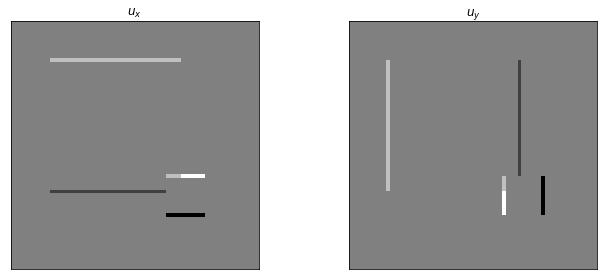

In [35]:
# make image
n = 128
u = np.zeros((n,n))
u[20:88, 20:88] = .5
u[80:100, 80:100] = 1

# gradient
ux = np.gradient(u, axis=0)
uy = np.gradient(u, axis=1)

# plot
plot_images([ux, uy], [r'$u_x$',r'$u_y$'], fname='gradients.png', scale=[-.5,.5])

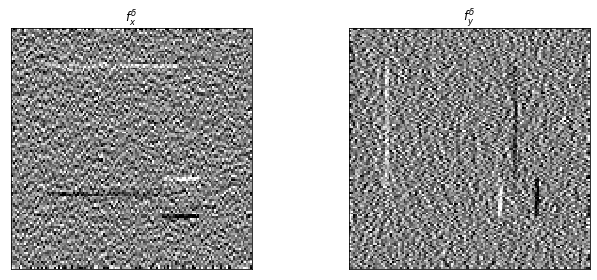

In [38]:
# make image
n = 128
u = np.zeros((n,n))
u[20:88, 20:88] = .5
u[80:100, 80:100] = 1

# add noise
delta = 1e-1
f_delta = random_noise(u, var = delta, clip=False)

# gradient
fx = np.gradient(f_delta, axis=0)
fy = np.gradient(f_delta, axis=1)

# plot
plot_images([fx, fy], [r'$f^\delta_x$',r'$f^\delta_y$'], fname='gradients_noise.png', scale=[-.5,.5])

![](gradients.png)

![](gradients_noise.png)

## Why do we get a sparse solution?

* The $\ell_1$ penalty puts more weight on small entries and less on large ones as compared to $\ell_2$
* A minimum $\ell_1$-solution is more likely to be sparse than a minimum $\ell_2$ solution

## Assignment: TV denoising

* investigate effect of contrast vs. noise
* investigate bias-variance trade-off
* investigate performance of TV on more complex images


# Intermezzo: Compressed Sensing

# Deconvolution with $\ell_1$ regularisation

In general, we want to solve

$$\min_{u} \frac{1}{2}\|Ku - f^\delta\|_2^2 + \alpha \|Ru\|_1.$$

* the corresponding denoising problem is central to solving the deconvolution problem
* ..

# Machine learning

* for denoising
* as regulariser